In [1]:
%env THEANO_FLAGS='device=cuda','floatX=float32'

env: THEANO_FLAGS='device=cuda','floatX=float32'


In [2]:
!pip install --force --quiet --no-deps git+https://github.com/maxim-borisyak/craynn.git@develop

In [3]:
import craynn
import lasagne
import theano
import theano.tensor as T
import numpy as np

from craynn.layers import *
from craynn.subnetworks import *
from craynn.networks import *
from craynn.updates import *

from craynn.viz import draw_to_notebook

Using cuDNN version 7001 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [4]:
cnn = net((None, 10, 32, 32))(
    diff(16), max_pool(),
    diff(32), max_pool(),
    diff(64), max_pool(),
    diff(128), max_pool(),
    diff(256), max_pool(),
    diff1x1(1, f=lambda x: x),
    flatten(1)
)

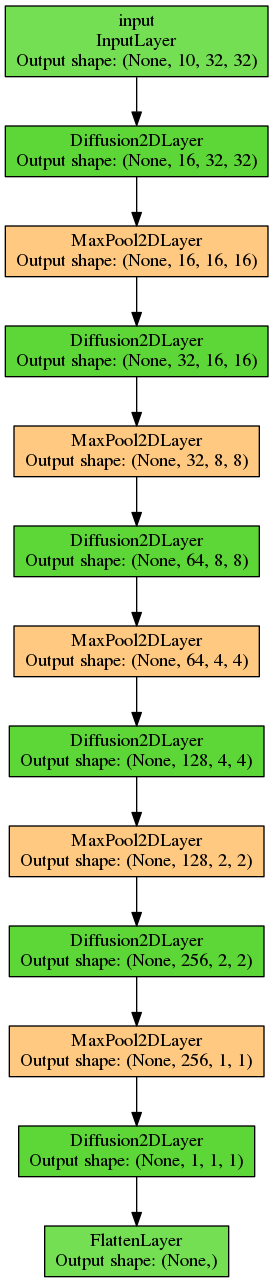

In [5]:
draw_to_notebook(lasagne.layers.get_all_layers(cnn.outputs))

In [6]:
from theano.sandbox.rng_mrg import MRG_RandomStreams

srng = MRG_RandomStreams()

In [7]:
X_normal = T.ftensor4()
X_anomalious = T.ftensor4()
X_noise = srng.binomial(size=(128, 10, 32, 32), p=0.1).astype('float32')

In [8]:
f_normal, = cnn(X_normal)
f_anomalious, = cnn(X_anomalious)
f_noise, = cnn(X_noise)

alpha = 0.1

In [9]:
loss = 0.5 * T.mean(T.nnet.softplus(-f_normal)) + \
       0.5 * alpha * T.mean(T.nnet.softplus(f_anomalious)) + \
       0.5 * (1 - alpha) * T.mean(T.nnet.softplus(f_noise))

In [10]:
upd = adamax(loss, cnn.params(trainable=True))

In [11]:
train = theano.function(
    inputs=[X_normal, X_anomalious],
    outputs=loss,
    updates=upd
)

In [12]:
predict = theano.function(inputs=[X_normal], outputs=f_normal)

## Data

In [13]:
data_normal = np.load('events_train.npy').astype('float32')
print(data_normal.dtype)
print(data_normal.shape)

float32
(32768, 10, 32, 32)


In [14]:
data_anomalious = np.load('anomalious_train.npy').astype('float32')[:16]
print(data_anomalious.dtype)
print(data_anomalious.shape)

float32
(16, 10, 32, 32)


## Training

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

from craynn.viz import SNNWatcher
from craynn.updates import streams

In [16]:
n_epoches = 128
n_batches = 128

normal_stream = streams.inf_random(data_normal.shape[0], batch_size=32)
anomalious_stream = streams.inf_random(data_anomalious.shape[0], batch_size=32)

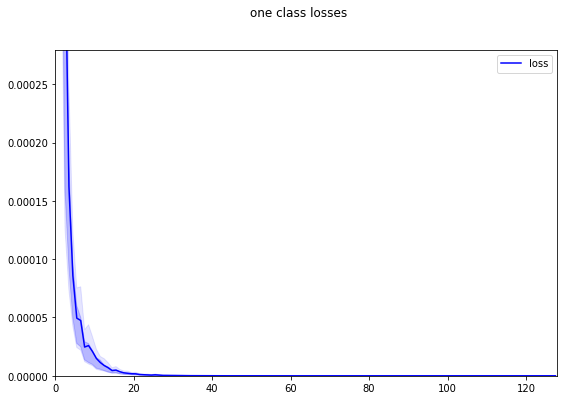

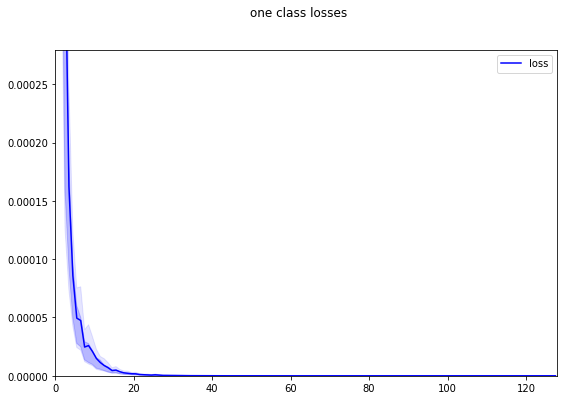

In [17]:
watcher = SNNWatcher('one class losses', mode='fill')
losses = np.ndarray(shape=(n_epoches, n_batches))

for epoch in range(n_epoches):
    for i in range(n_batches):
        losses[epoch, i] = train(
            data_normal[next(normal_stream)],
            data_anomalious[next(anomalious_stream)]
        )
    watcher.draw(losses[:(epoch + 1)])

## Testing

In [18]:
del data_normal
del data_anomalious

In [19]:
data_anomalious_test = np.load('./anomalious_test.npy')
p_anomalious = np.hstack([
    predict(data_anomalious_test[indx])
    for indx in streams.seq(data_anomalious_test.shape[0], batch_size=128)
])

In [20]:
del data_anomalious_test

In [21]:
data_normal_test = np.load('./events_test.npy')
p_normal = np.hstack([
    predict(data_normal_test[indx])
    for indx in streams.seq(data_normal_test.shape[0], batch_size=128)
])

In [22]:
del data_normal_test

In [23]:
p = np.hstack([p_normal, p_anomalious])

In [24]:
y = np.ndarray(shape=(p_normal.shape[0] + p_anomalious.shape[0], ), dtype='uint8')

y[:p_normal.shape[0]] = 1
y[p_normal.shape[0]:] = 0

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

In [26]:
auc = roc_auc_score(y, p)

fpr, tpr, _ = roc_curve(y, p)

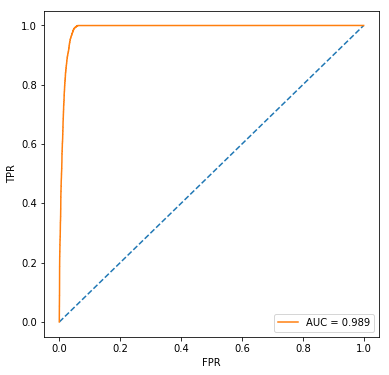

In [27]:
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], '--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.plot(fpr, tpr, label='AUC = %.3lf' % auc)

plt.legend()

plt.show()